# **Baseline Model for Multi-hop Question & Answering (Longformer + HotpotQA)**
The pre-trained `allenai/longformer-large-4096-finetuned-triviaqa` model checkpoint (for single-hop QA) is taken from Hugging Face for setting the baseline for the HotpotQA data set.


https://huggingface.co/allenai/longformer-large-4096-finetuned-triviaqa<br>
https://hotpotqa.github.io/index.html

NOTE: Runtime is about 1.5 hours even for inferencing the answers on test set. 
It is an issue Tensorflow 2.0. 
For quick experiments, execute the notebook till Manual Inference block and change the id with random values in range (0 - 7478)


In [ ]:
!pip install -q transformers==3.5.1

     |████████████████████████████████| 1.3MB 23.8MB/s 
     |████████████████████████████████| 2.9MB 57.1MB/s 
     |████████████████████████████████| 1.1MB 58.2MB/s 
     |████████████████████████████████| 890kB 56.4MB/s 


In [ ]:
import re
import json
import time
import random
import string
import tarfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import Counter

import tensorflow as tf
from transformers import LongformerTokenizer, TFLongformerForQuestionAnswering

In [ ]:
# Configurations
MODEL = 'allenai/longformer-large-4096-finetuned-triviaqa'
MAX_LEN = 512
PUBLIC_ACCESS = True

In [ ]:
# TAR.GZ extractor
def extract_tar(fname):
  tar = tarfile.open(fname, "r:gz")
  tar.extractall()
  tar.close()

# Download Files
if PUBLIC_ACCESS:
  !gdown --id "1pFJ0NAvMSn7C-vI-hzeSsCG7ppJGa8EV"
  extract_tar('HotPotQA_EM.tar.gz')
else:
  extract_tar('/content/drive/MyDrive/data/hotpot/HotPotQA_EM.tar.gz')

Downloading...
From: https://drive.google.com/uc?id=1pFJ0NAvMSn7C-vI-hzeSsCG7ppJGa8EV
To: /content/HotPotQA_EM.tar.gz
221MB [00:03, 67.5MB/s]


In [ ]:
# Import Data
with open('train_em.json') as f:
    train_data = json.load(f)
with open('val_em.json') as f:
    val_data = json.load(f)

In [ ]:
# Print header
train_data[0].keys()

dict_keys(['supporting_facts', 'level', 'question', 'context', 'answer', '_id', 'type'])

In [ ]:
# Print a question, context and answer triplet
print(train_data[0]['question'], train_data[0]['answer'], train_data[0]['context'], sep='\n')

Who was once considered the best kick boxer in the world, however he has been involved in a number of controversies relating to his "unsportsmanlike conducts" in the sport and crimes of violence outside of the ring.
Badr Hari
['The 1998 Verano de Escándalo (Spanish for "Summer of Scandal") was the second annual "Verano de Escandalo" professional wrestling show promoted by AAA. The show took place on September 18, 1998, in Madero, Tamaulipas, Mexico. The main event featured steel cage match between the teams of Heavy Metal and Blue Demon Jr. and Kick Boxer and Abismo Negro. The stipulation of the main event was that if the team of Heavy Metal and Blue Demon Jr. lost referee Guicho Dominguez would be referee El Tirante\'s "slave" for a week. If Kick Boxer and Abismo Negro lost El Tirantes would be Guicho Dominguez\'s slave for a week.', 'Triplemanía VII was the seventh "Triplemanía" wrestling show promoted by AAA. The show took place on June 11, 1999, in Madero, Mexico. The Main event fe

In [ ]:
# Convert JSON to DF
df_train = pd.DataFrame(train_data)
df_val = pd.DataFrame(val_data)

In [ ]:
# Converts list of sentences to paragraph string
def paragraph_maker(context):
    # context = []
    # for i in x:
    #     context.append(''.join(i))
    context = ' '.join(context)
    return context

# Apply paragraph maker
df_train['text'] = df_train['context'].apply(paragraph_maker)
df_val['text'] = df_val['context'].apply(paragraph_maker)

In [ ]:
# Print head
df_train.head(3)

,supporting_facts,level,question,context,answer,_id,type,text
0,"[[Global Fighting Championship, 1], [Global Fi...",easy,Who was once considered the best kick boxer in...,"[The 1998 Verano de Escándalo (Spanish for ""Su...",Badr Hari,5a832c3455429954d2e2ec41,bridge,"The 1998 Verano de Escándalo (Spanish for ""Sum..."
1,"[[Malcolm Smith (American football), 3], [Supe...",easy,In which American football game was Malcolm Sm...,[Winston Lagoon ( ) is a lagoon indenting the ...,Super Bowl XLVIII,5ade025e5542997dc790711e,bridge,Winston Lagoon ( ) is a lagoon indenting the s...
2,"[[Hurt Locker (musical), 3], [Metallica, 2]]",easy,What are the names of the current members of ...,"[Joseph ""Joey"" Vera (born April 24, 1963) is a...","Hetfield and Ulrich, longtime lead guitarist K...",5ac2a5d455429921a00ab01b,bridge,"Joseph ""Joey"" Vera (born April 24, 1963) is an..."


In [ ]:
# Divide data according to difficulty levels
df_val_easy = df_val.loc[df_val['level'] == 'easy']
df_val_medium = df_val.loc[df_val['level'] == 'medium']
df_val_hard = df_val.loc[df_val['level'] == 'hard']

## Plot Token Count Distribution

In [ ]:
# Extract number of tokens per doc
sizes = []
for i in df_train['text'].to_list()+df_val['text'].to_list():
    sizes.append(len(i.split()))
sort_size = sorted(sizes)

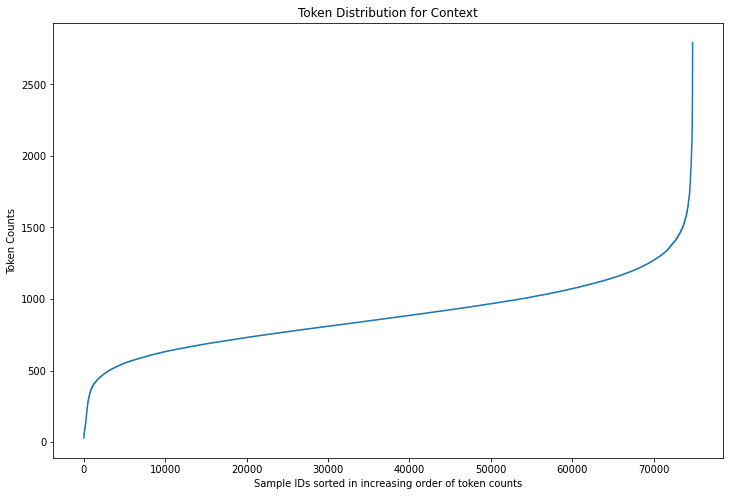

In [ ]:
# Plot token distribution
plt.figure(figsize=(12,8))
plt.title('Token Distribution for Context')
plt.xlabel('Sample IDs sorted in increasing order of token counts')
plt.ylabel('Token Counts')
plt.plot(sort_size)

## Pre-trained Longformer

In [ ]:
# Import tokenizer and model
tokenizer = LongformerTokenizer.from_pretrained(MODEL)
model = TFLongformerForQuestionAnswering.from_pretrained(MODEL)

All model checkpoint layers were used when initializing TFLongformerForQuestionAnswering.

All the layers of TFLongformerForQuestionAnswering were initialized from the model checkpoint at allenai/longformer-large-4096-finetuned-triviaqa.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFLongformerForQuestionAnswering for predictions without further training.


In [ ]:
# Funtion to generate answer for a question and text string
def get_answer(question, text):
    inputs = tokenizer.encode_plus(question, text, return_tensors='tf', max_length=MAX_LEN, truncation=True)
    input_ids = inputs["input_ids"].numpy().tolist()
    start_scores, end_scores = model(inputs)

    start = tf.math.argmax(start_scores, axis=1).numpy()[0]
    end = tf.math.argmax(end_scores, axis=1).numpy()[0]
    
    all_tokens = tokenizer.convert_ids_to_tokens(input_ids[0])
    answer = ''.join(all_tokens[start: end + 1]).replace('▁', ' ').strip()
    answer = answer.replace('[SEP]', '')
    return answer if ('[CLS]' not in answer) and (len(answer) != 0) else ''

## Manual Inference

In [ ]:
# Print an example inference from model
id = 1
print(get_answer(df_val['question'].iloc[id], df_val['text'].iloc[id]))
print(df_val['answer'].iloc[id])

Ġpoets
poet


## Answer Prediction

In [ ]:
# Predict answer for a DF with columns 'question' and 'paragraphs'
def predict_answers(df):
    pred_answers = []
    cnt_ans_found = 0
    for i in tqdm(range(len(df))):
        a = ''
        try:
            a = get_answer(df['question'].iloc[i], df['text'].iloc[i])
            if a != '':
                cnt_ans_found += 1
        except:
            print(f'Error in iteration {i}')
        pred_answers.append(a)
    return pred_answers, cnt_ans_found

In [ ]:
# Easy Predictions
t0 = time.time()
pred_answers_easy, cnt_ans_found_easy = predict_answers(df_val_easy)

100%|██████████| 1797/1797 [36:05<00:00,  1.20s/it]


In [ ]:
# Medium Predictions
t0 = time.time()
pred_answers_medium, cnt_ans_found_medium = predict_answers(df_val_medium)

100%|██████████| 5681/5681 [1:54:09<00:00,  1.21s/it]


In [ ]:
# Hard Predictions
t0 = time.time()
pred_answers_hard, cnt_ans_found_hard = predict_answers(df_val_hard)

0it [00:00, ?it/s]


In [ ]:
print(f'Easy Questions Answered {cnt_ans_found_easy} / {len(df_val_easy)}')

Easy Questions Answered 1674 / 1797


In [ ]:
print(f'Medium Questions Answered {cnt_ans_found_medium} / {len(df_val_medium)}')

Medium Questions Answered 5297 / 5681


In [ ]:
print(f'Hard Questions Answered {cnt_ans_found_hard} / {len(df_val_hard)}')

Hard Questions Answered 0 / 0


## Evaluation

In [ ]:
# Evaluation functions taken from HotpotQA
def normalize_answer(s):

    def remove_articles(text):
        return re.sub(r'\b(a|an|the)\b', ' ', text)

    def white_space_fix(text):
        return ' '.join(text.split())

    def remove_punc(text):
        exclude = set(string.punctuation)
        return ''.join(ch for ch in text if ch not in exclude)

    def lower(text):
        return text.lower()

    return white_space_fix(remove_articles(remove_punc(lower(s))))

# Exact Match score
def exact_match_score(prediction, ground_truth):
    return (normalize_answer(prediction) == normalize_answer(ground_truth))

# FPR metrics
def f1_score(prediction, ground_truth):
    normalized_prediction = normalize_answer(prediction)
    normalized_ground_truth = normalize_answer(ground_truth)

    ZERO_METRIC = (0, 0, 0)

    if normalized_prediction in ['yes', 'no', 'noanswer'] and normalized_prediction != normalized_ground_truth:
        return ZERO_METRIC
    if normalized_ground_truth in ['yes', 'no', 'noanswer'] and normalized_prediction != normalized_ground_truth:
        return ZERO_METRIC

    prediction_tokens = normalized_prediction.split()
    ground_truth_tokens = normalized_ground_truth.split()
    common = Counter(prediction_tokens) & Counter(ground_truth_tokens)
    num_same = sum(common.values())
    if num_same == 0:
        return ZERO_METRIC
    precision = 1.0 * num_same / len(prediction_tokens)
    recall = 1.0 * num_same / len(ground_truth_tokens)
    f1 = (2 * precision * recall) / (precision + recall)
    return f1, precision, recall

In [ ]:
# Normalize the predictions by removing the seperator
pred_answers_easy_n = [' '.join(i.split('Ġ')) for i in pred_answers_easy]
pred_answers_medium_n = [' '.join(i.split('Ġ')) for i in pred_answers_medium]
pred_answers_hard_n = [' '.join(i.split('Ġ')) for i in pred_answers_hard]

In [ ]:
# Create a list of true answers for easy and medium
true_answers_easy = df_val_easy['answer'].to_list()
true_answers_medium = df_val_medium['answer'].to_list()
true_answers_hard = df_val_hard['answer'].to_list()

In [ ]:
# Calculate F1 and exact match score EM for each document in both easy and medium sets
f1_easy = []
em_easy = []
p_easy = []
r_easy = []
f1_medium = []
em_medium = []
p_medium = []
r_medium = []
f1_hard = []
em_hard = []
p_hard = []
r_hard = []

# Easy
for i in range(len(pred_answers_easy_n)):
    fpr = f1_score(pred_answers_easy_n[i], true_answers_easy[i])
    f1_easy.append(fpr[0])
    p_easy.append(fpr[1])
    r_easy.append(fpr[2])
    em_easy.append(exact_match_score(pred_answers_easy_n[i], true_answers_easy[i]))

# Medium
for i in range(len(pred_answers_medium_n)):
    fpr = f1_score(pred_answers_medium_n[i], true_answers_medium[i])
    f1_medium.append(fpr[0])
    p_medium.append(fpr[1])
    r_medium.append(fpr[2])
    em_medium.append(exact_match_score(pred_answers_medium_n[i], true_answers_medium[i]))

# Hard
for i in range(len(pred_answers_hard_n)):
    fpr = f1_score(pred_answers_hard_n[i], true_answers_hard[i])
    f1_hard.append(fpr[0])
    p_hard.append(fpr[1])
    r_hard.append(fpr[2])
    em_hard.append(exact_match_score(pred_answers_hard_n[i], true_answers_hard[i]))

In [ ]:
# Trained model scores
print(f"Overall Mean F1: {np.mean(f1_easy+f1_medium+f1_hard)}")
print(f"Overall Mean Precision: {np.mean(p_easy+p_medium+p_hard)}")
print(f"Overall Mean Recall: {np.mean(r_easy+r_medium+r_hard)}")
print(f"Overall Mean EM: {np.mean(em_easy+em_medium+em_hard)}")

print(f"Easy Mean F1: {np.mean(f1_easy)}")
print(f"Easy Mean EM: {np.mean(em_easy)}")

print(f"Medium Mean F1: {np.mean(f1_medium)}")
print(f"Medium Mean EM: {np.mean(em_medium)}")

# print(f"Hard Mean F1: {np.mean(f1_hard)}")
# print(f"Hard Mean EM: {np.mean(em_hard)}")

Overall Mean F1: 0.33522232311264094
Overall Mean Precision: 0.36070985183452764
Overall Mean Recall: 0.350776040327125
Overall Mean EM: 0.2713292324150842
Easy Mean F1: 0.3949259480218869
Easy Mean EM: 0.3099610461880913
Medium Mean F1: 0.31633701877151876
Medium Mean EM: 0.2591093117408907
